In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from pyuvdata import UVData

In [2]:
import scipy

In [3]:
import polcal

In [4]:
import copy

In [5]:
import time

In [6]:
import glob

In [7]:
 from scipy import interpolate

## Selecting Simulation Data And Raw Data  

Exclude `bad' antennas

In [8]:
good_ants = list(set([9,10,20,22,31,43,53,64,65,72,80,81,88,89,96,97,104,105,112]) - set([22,43,80,81]))

In [18]:
uvd_raw = UVData()
uvd_raw.read(glob.glob('/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/RawData/2457548/zen.2457548.16694.uvcRP.uvh5'), antenna_nums=good_ants)

In [19]:
uvd_sim = UVData()
uvd_sim.read(glob.glob('/lustre/aoc/projects/hera/jaguirre/HERA19Summer2020/Simulation/zen.2457755.59672.uvCP.uvh5'), antenna_nums=good_ants)

In [45]:
#print(np.unique(uvd_raw_.time_array), np.unique(uvd_raw_.lst_array), np.mean(np.diff(np.unique(uvd_raw_.time_array))), uvd_raw_.Ntimes)

In [46]:
#print(np.unique(uvd_sim_.time_array), np.unique(uvd_sim_.lst_array), np.mean(np.diff(np.unique(uvd_sim_.time_array))), uvd_sim_.Ntimes)

#### select the time_range

In [21]:
sim_start_idx = np.argwhere(np.unique(uvd_sim.lst_array)>np.unique(uvd_raw.lst_array)[0])[0]
print(sim_start_idx)
sim_start = np.unique(uvd_sim.time_array)[sim_start_idx][0]
print(np.unique(uvd_sim.lst_array)[sim_start_idx][0])
sim_end = np.unique(uvd_sim.time_array)[-1]
print(np.unique(uvd_sim.lst_array)[-1])

[19]
2.775733595166588
2.8077241081376183


In [22]:
raw_end_idx = np.argwhere(np.unique(uvd_raw.lst_array)<np.unique(uvd_sim.lst_array)[-1])[-1]
print(raw_end_idx)
raw_end = np.unique(uvd_raw.time_array)[raw_end_idx][0]
print(np.unique(uvd_raw.lst_array)[raw_end_idx][0])
raw_start = np.unique(uvd_raw.time_array)[0]
print(np.unique(uvd_raw.lst_array)[0])

[41]
2.8073953800665876
2.775292995261077


#### Make 'phased' copy and convert to uvfits

In [23]:
uvd_raw_copy = copy.deepcopy(uvd_raw)

In [24]:
uvd_sim_copy = copy.deepcopy(uvd_sim)

In [25]:
uvd_raw_copy.phase_to_time(raw_start)

In [26]:
uvd_sim_copy.phase_to_time(sim_start)

In [27]:
print(uvd_raw_copy.phase_center_dec_degrees,uvd_raw_copy.phase_center_ra_degrees)

-30.63243747022536 158.82193200367004


In [28]:
print(uvd_sim_copy.phase_center_dec_degrees,uvd_sim_copy.phase_center_ra_degrees)

-30.635068086176993 158.83656282988696


## Apply Smirnov method on single frequency channel

In [29]:
uv_polcal = polcal.uvdata_pol_calibrator(model_data=uvd_sim, real_data=uvd_raw, mode="model_based")

In [43]:
sim_start-1e-5, sim_end+1e-5

(2457755.599121639, 2457755.6042191857)

In [44]:
raw_start-1e-5,raw_end+1e-5

(2457548.166989404, 2457548.1721047065)

In [35]:
freq = 500
uv_polcal.data_slice(base_time_range=[sim_start-1e-5, sim_end+1e-5], prod_time_range=[raw_start-1e-5,raw_end+1e-5], 
                             base_freq_range=[freq], prod_freq_range=[freq], use_all_ants=True)
start_time = time.time()
gain_array_iter, residuals = uv_polcal.Wirtinger_lm_cal(damping_para=2., update_damping_para_per_loop=True, Niteration=1000, verbose=True)
print("--- %s seconds ---" % (time.time() - start_time))

--- 32.22198486328125 seconds ---


#### residuals vs iterations

No handles with labels found to put in legend.


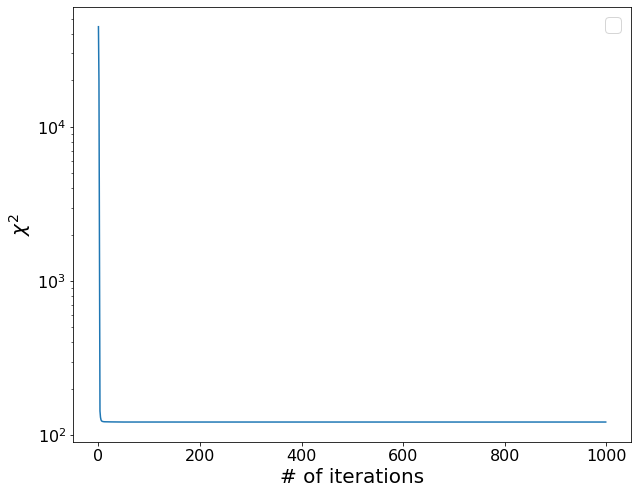

In [36]:
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(residuals)
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel(r"$\chi^2$", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)
ax.legend(loc='best', fontsize=20)

#### convergence of recovered gains

Text(0.5, 0, '# of iterations')

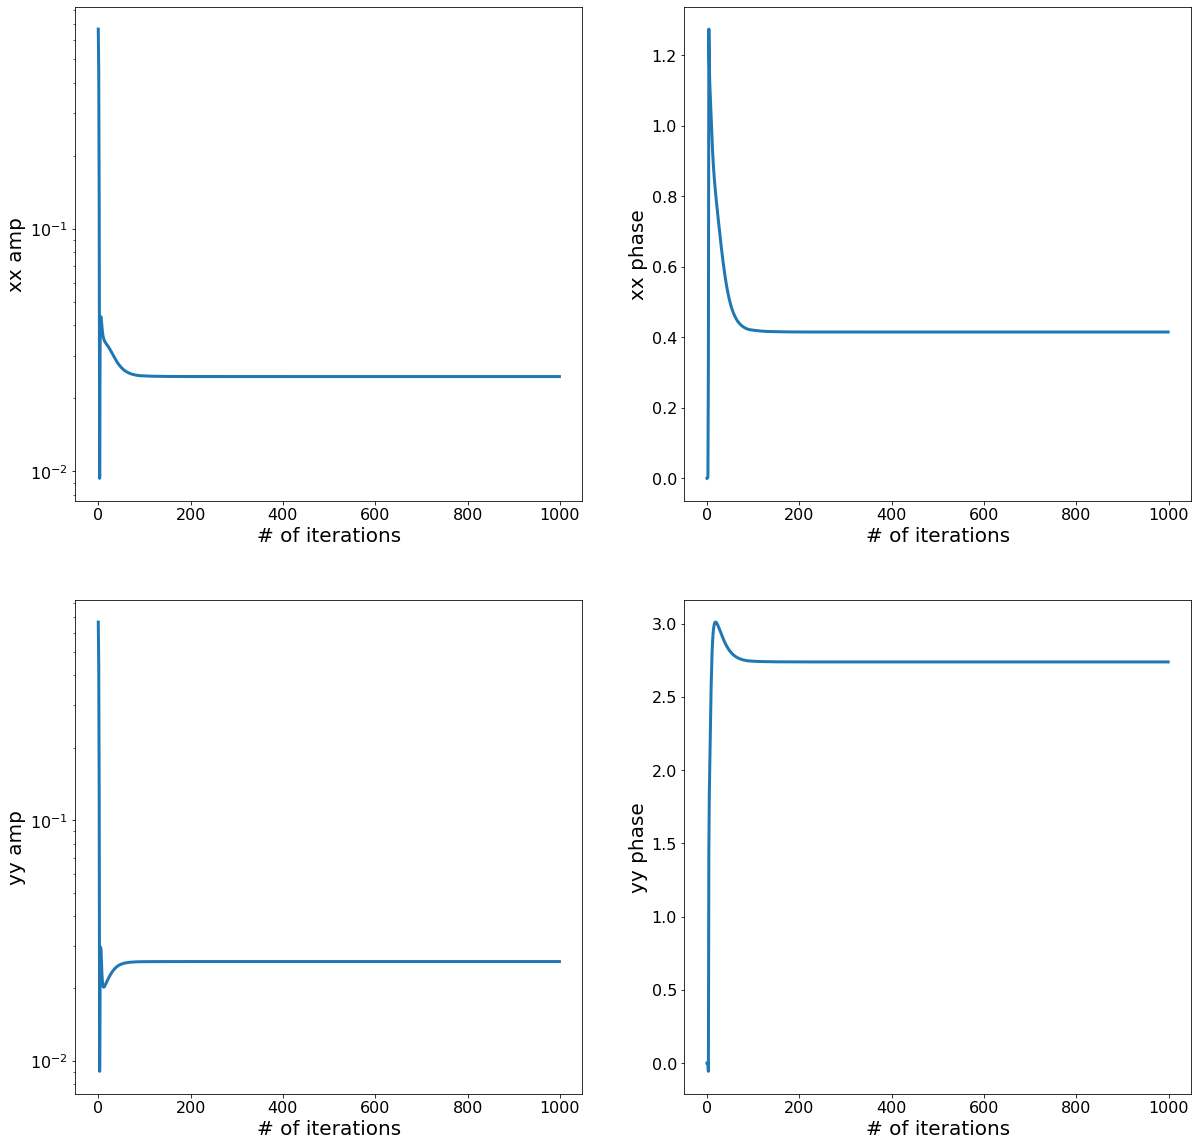

In [41]:
fig, axes = plt.subplots(figsize=(20,20), ncols=2, nrows=2)

ax = axes[0,0]
ax.plot(abs(gain_array_iter[:,0,0,0]), lw=3)
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("xx amp", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

ax = axes[0,1]
ax.plot(np.angle(gain_array_iter[:,0,0,0]) , lw=3)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("xx phase", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

ax = axes[1,0]
ax.plot(abs(gain_array_iter[:,0,1,1]), lw=3)
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("yy amp", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

ax = axes[1,1]
ax.plot(np.angle(gain_array_iter[:,0,1,1]) , lw=3)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("yy phase", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

Text(0.5, 0, '# of iterations')

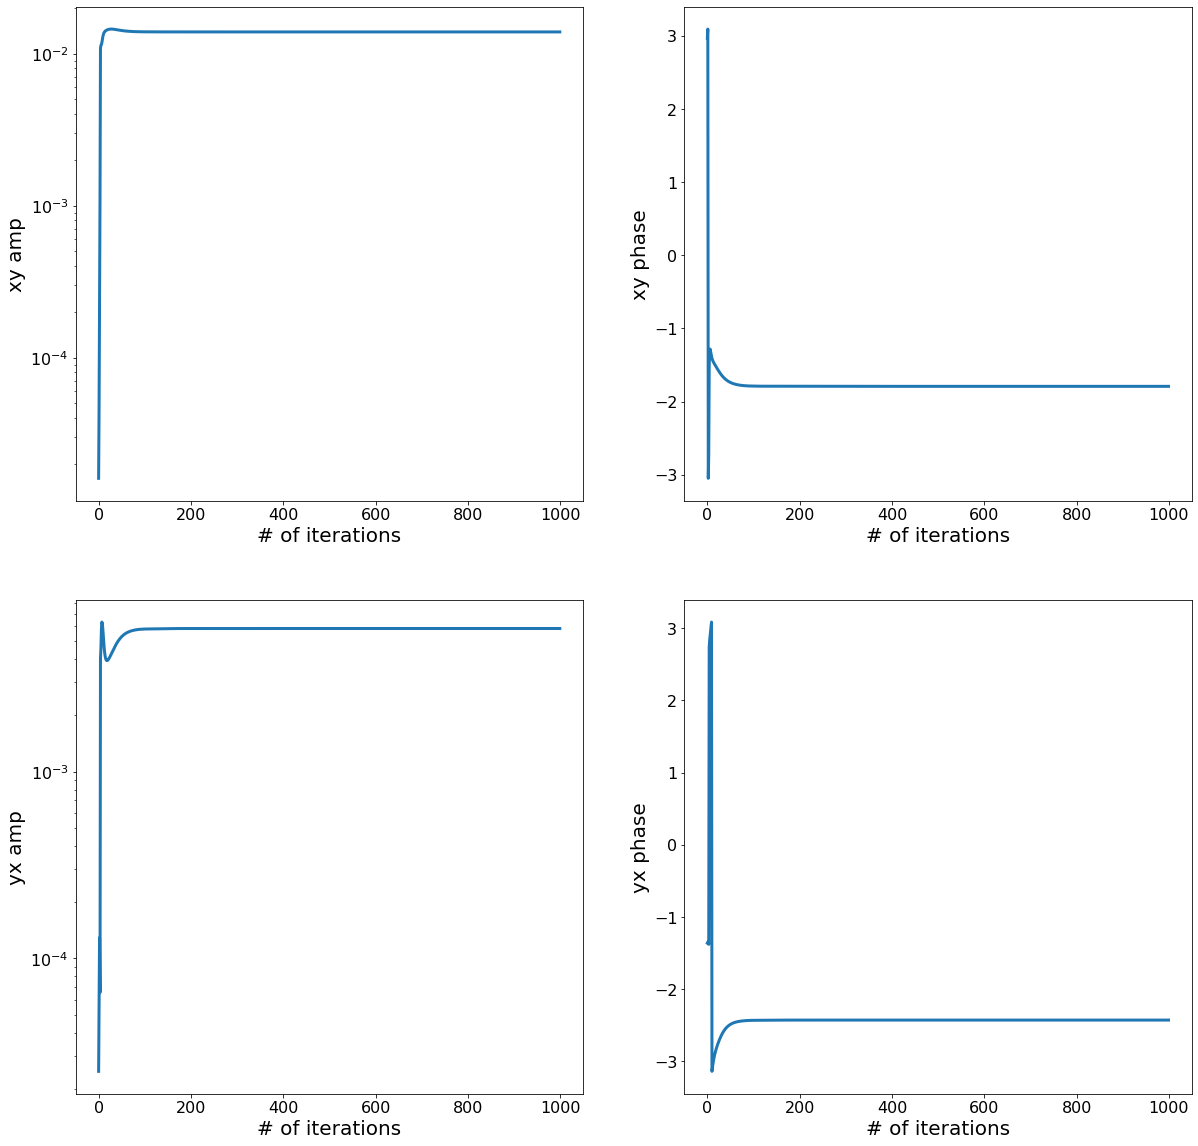

In [40]:
fig, axes = plt.subplots(figsize=(20,20), ncols=2, nrows=2)

ax = axes[0,0]
ax.plot(abs(gain_array_iter[:,10,0,1]), lw=3)
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("xy amp", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

ax = axes[0,1]
ax.plot(np.angle(gain_array_iter[:,10,0,1]) , lw=3)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("xy phase", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

ax = axes[1,0]
ax.plot(abs(gain_array_iter[:,10,1,0]), lw=3)
ax.set_yscale('log')
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("yx amp", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

ax = axes[1,1]
ax.plot(np.angle(gain_array_iter[:,10,1,0]) , lw=3)
ax.tick_params(axis='both', which='both', labelsize=16)
ax.set_ylabel("yx phase", fontsize=20)
ax.set_xlabel("# of iterations", fontsize=20)

#### Plot antenna position

In [71]:
antpos, ants = uvd_raw.get_ENU_antpos(center=True, pick_data_ants=False)

In [84]:
good_antpos = []
for good_ant in good_ants:
    good_antpos.extend(antpos[np.where(ants == good_ant)])
good_antpos = np.array(good_antpos)

Text(0, 0.5, 'Y-position [meters]')

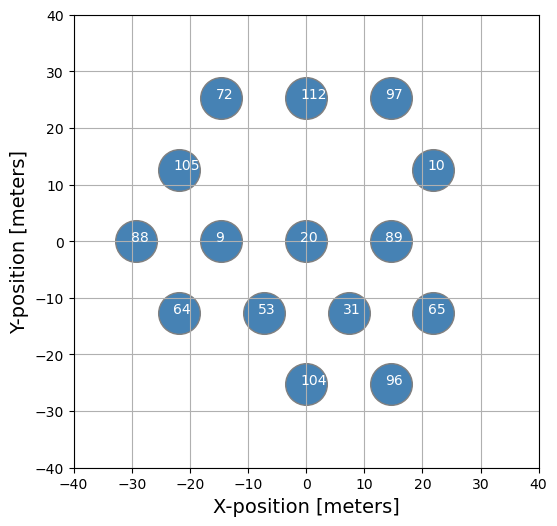

In [91]:
# plot array
fig, ax = plt.subplots(figsize=(6, 6), dpi=100)
ax.grid()
ax.scatter(good_antpos[:, 0], good_antpos[:, 1], edgecolor='grey', facecolor='steelblue', s=900)
for i in range(len(good_ants)): ax.text(good_antpos[i,0]-1, good_antpos[i,1], good_ants[i], fontsize=10, color='w')
ax.set_xlim(-40, 40)
ax.set_ylim(-40, 40)
ax.set_xlabel("X-position [meters]", fontsize=14)
ax.set_ylabel("Y-position [meters]", fontsize=14)

## Gains on the whole band

In [20]:
## Run calibration every 10 frequency channels

In [8]:
gain_info = np.load("gain_info_HERA19.npy")

In [10]:
gain_rp = polcal.gain_array_interpolate(gain_info, list(range(0,1024,10)))

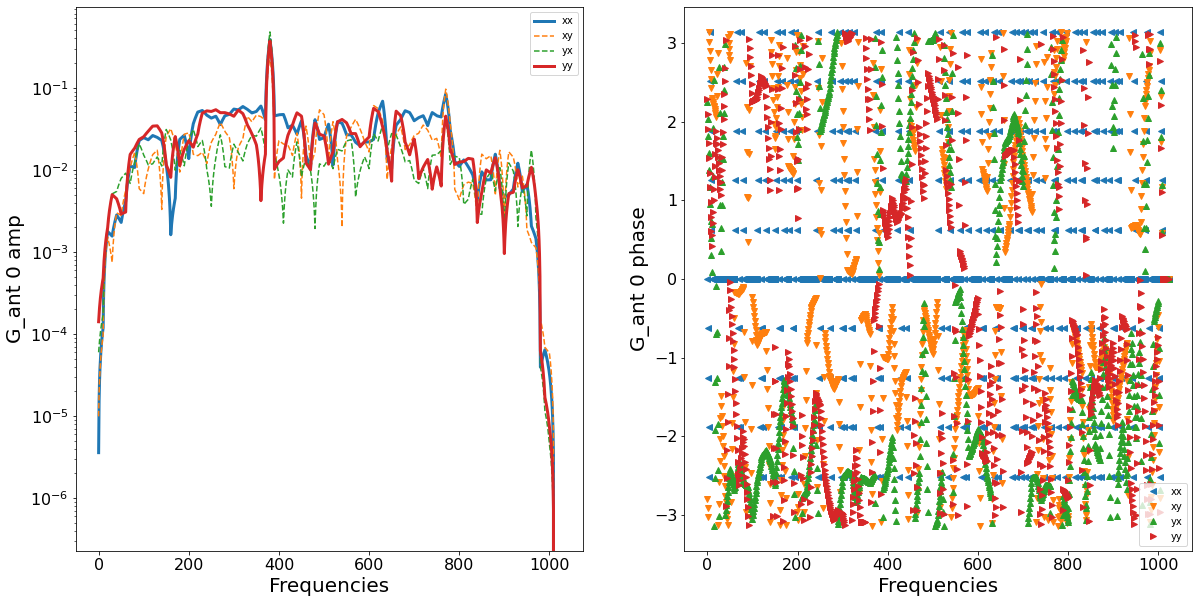

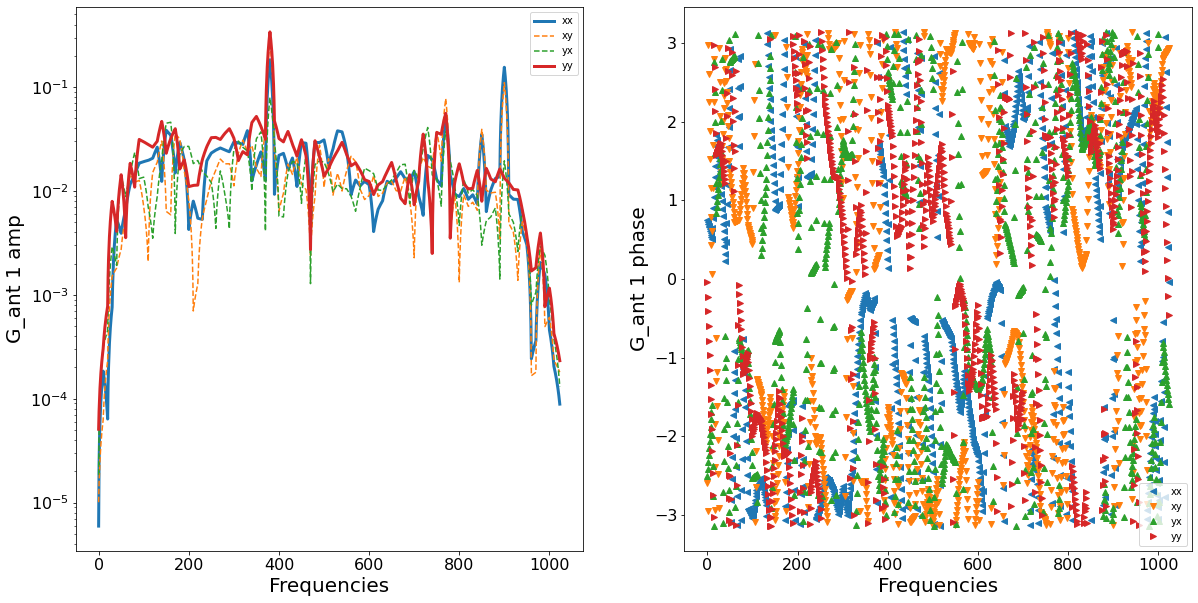

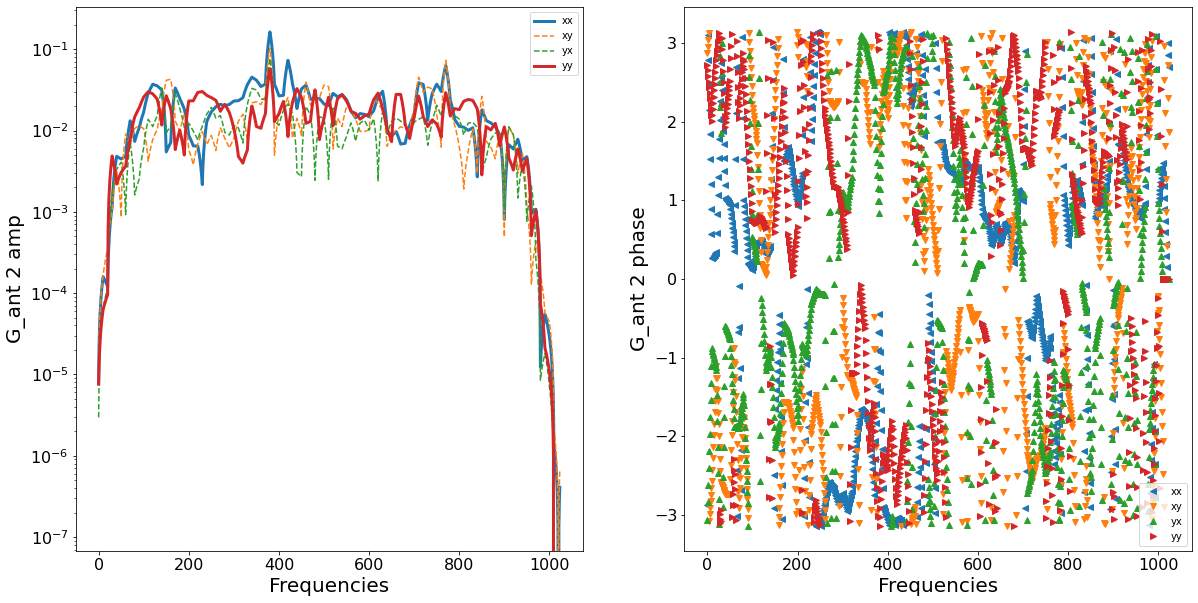

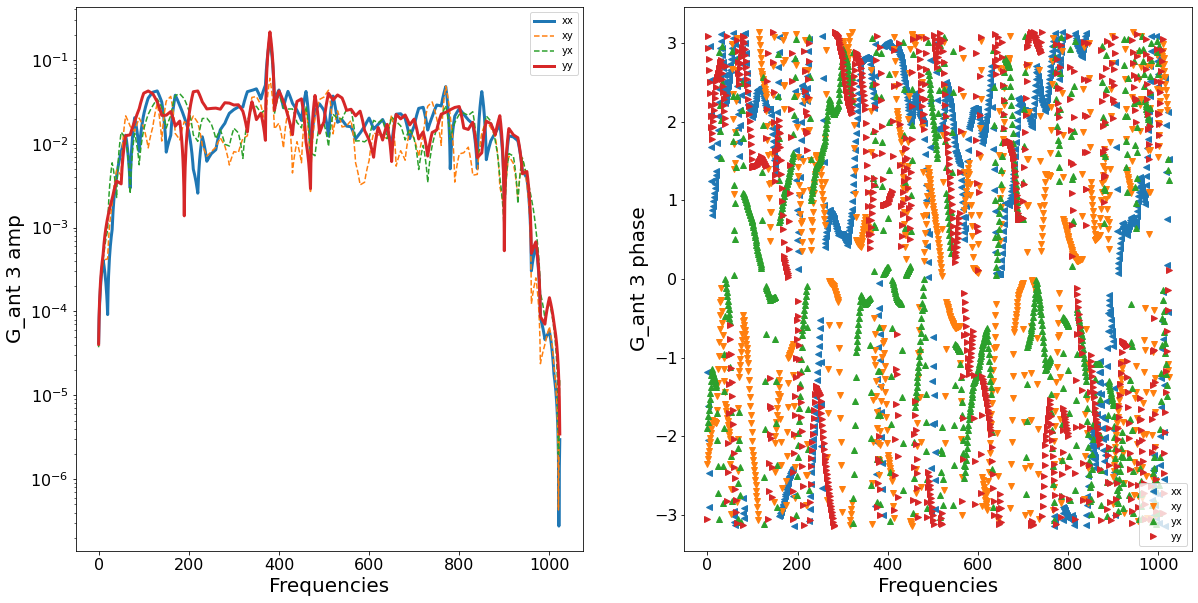

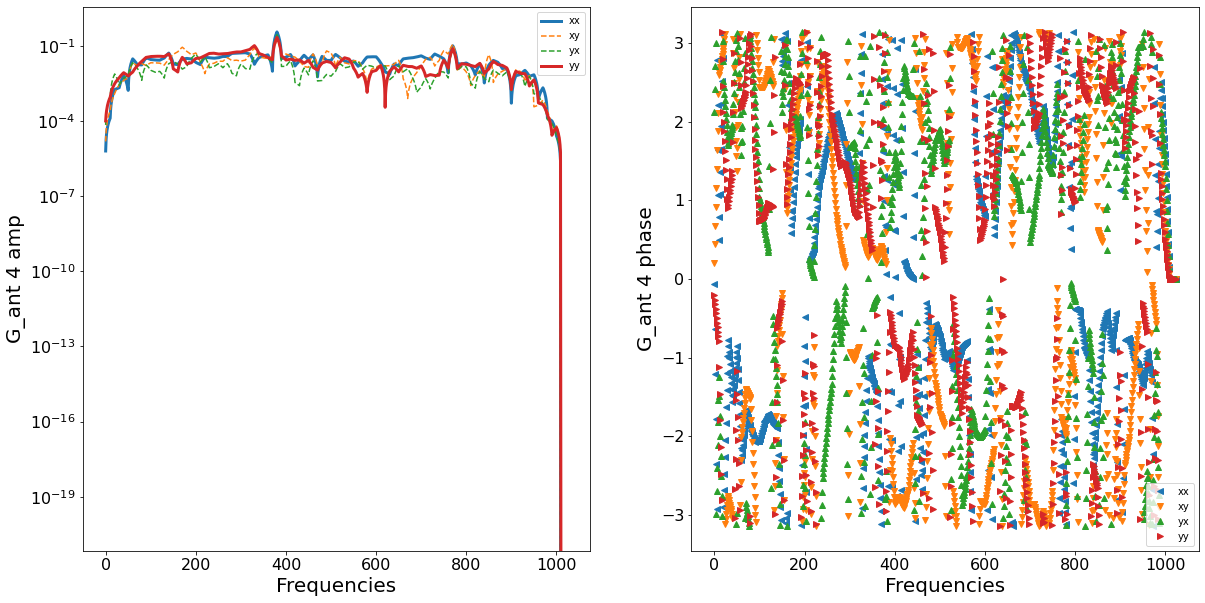

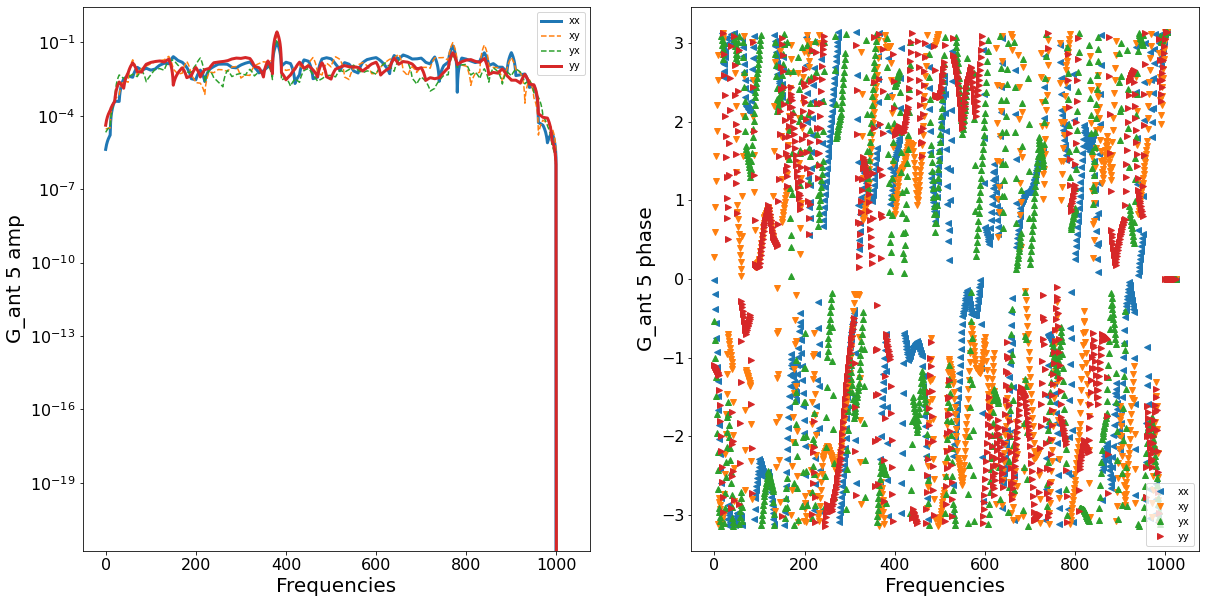

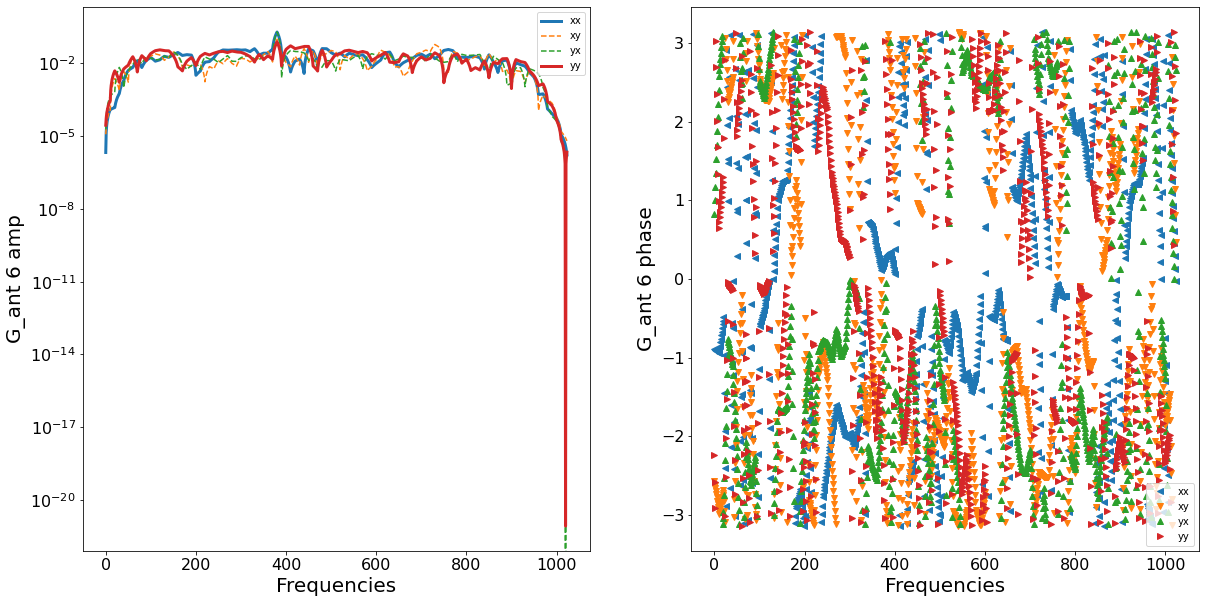

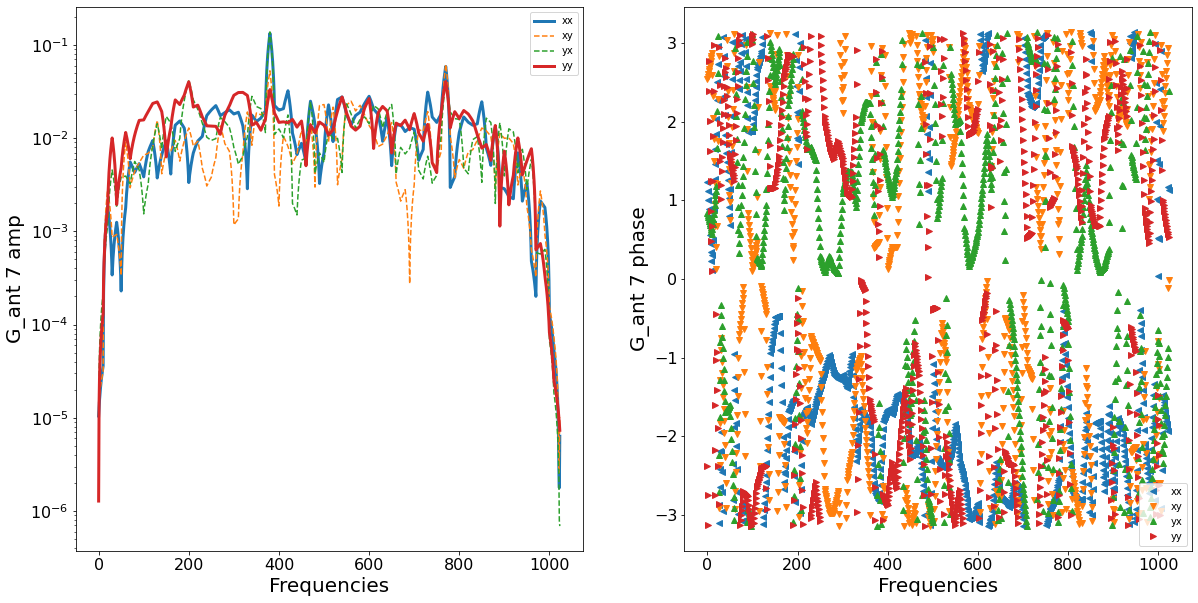

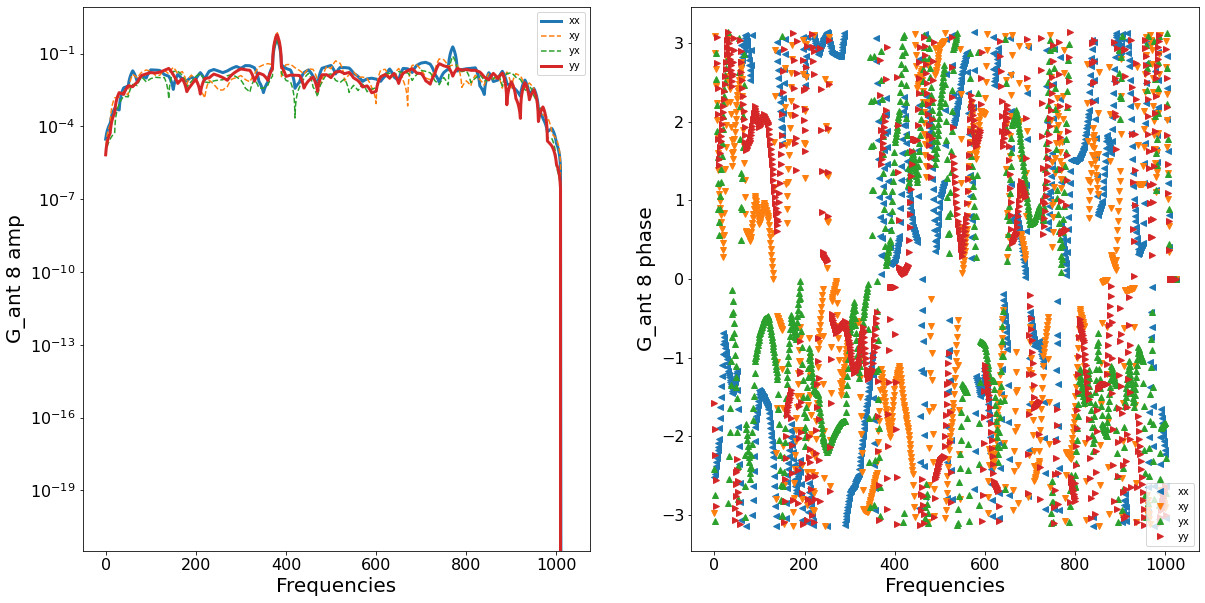

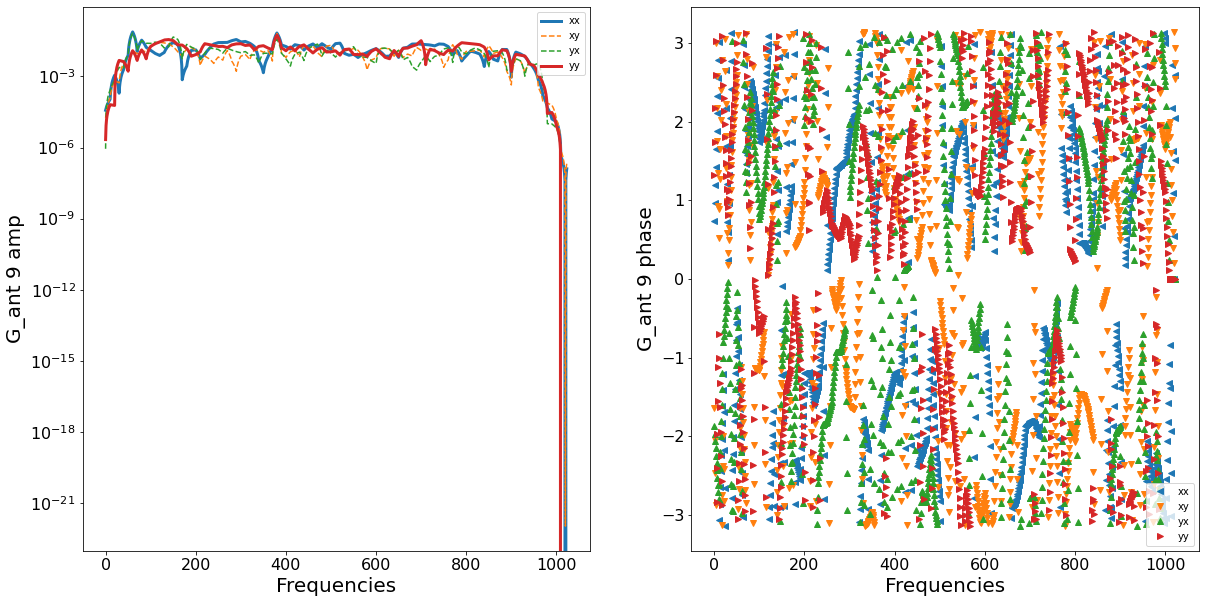

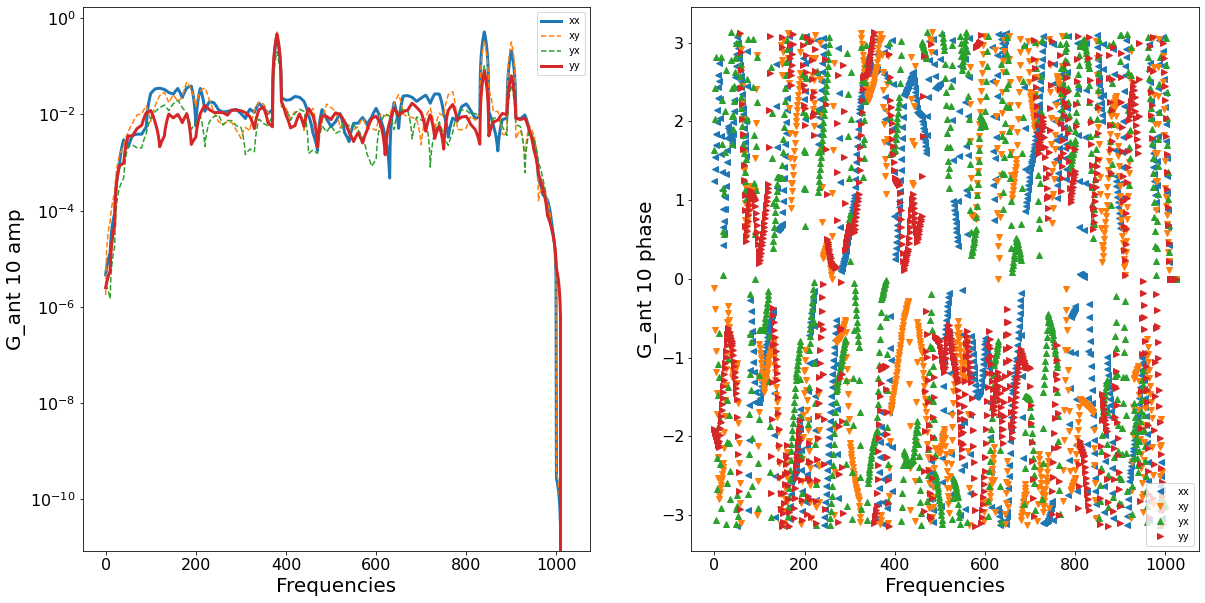

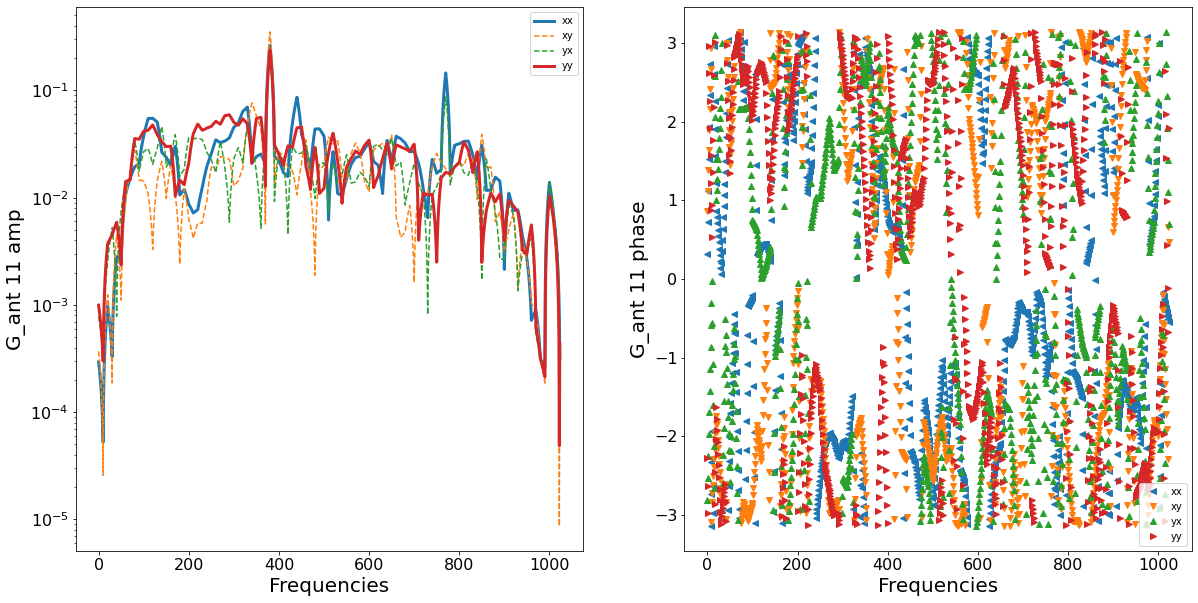

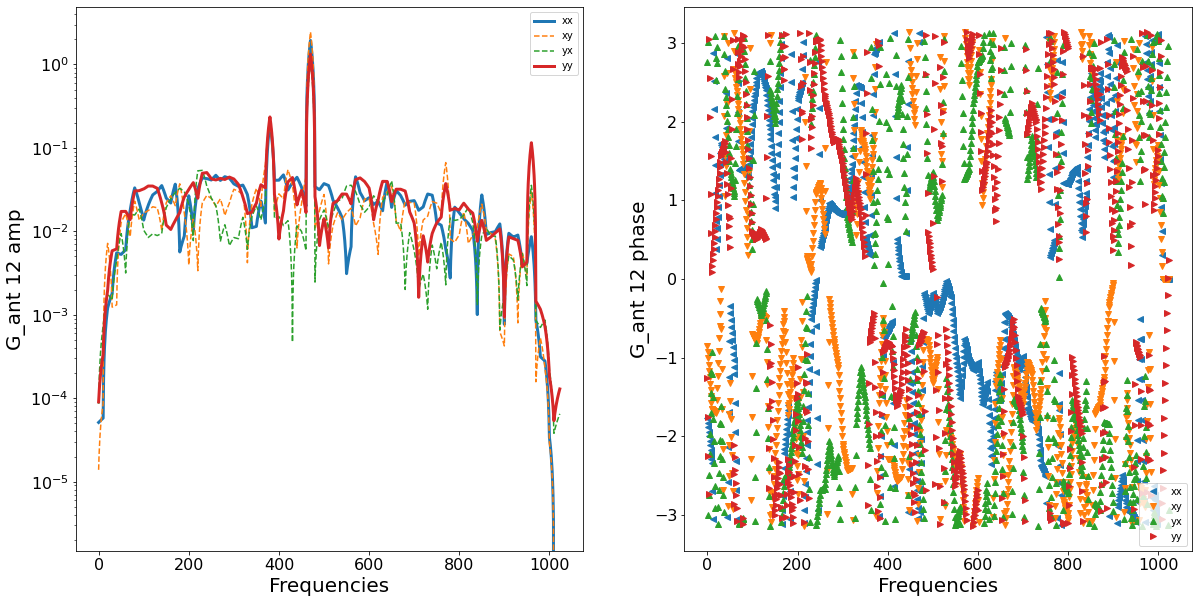

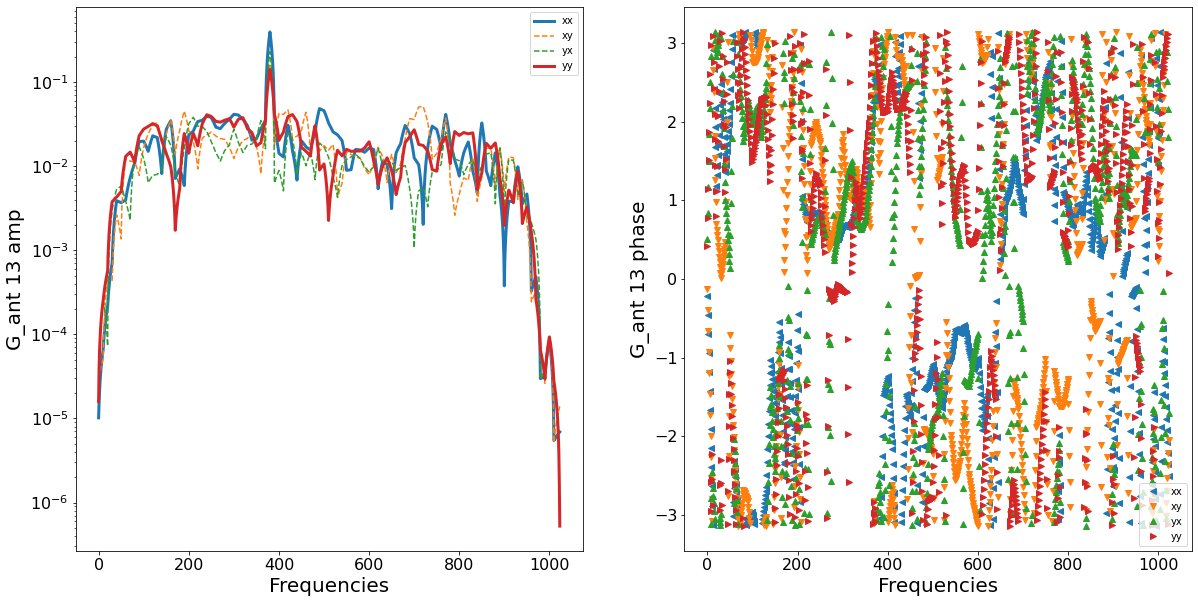

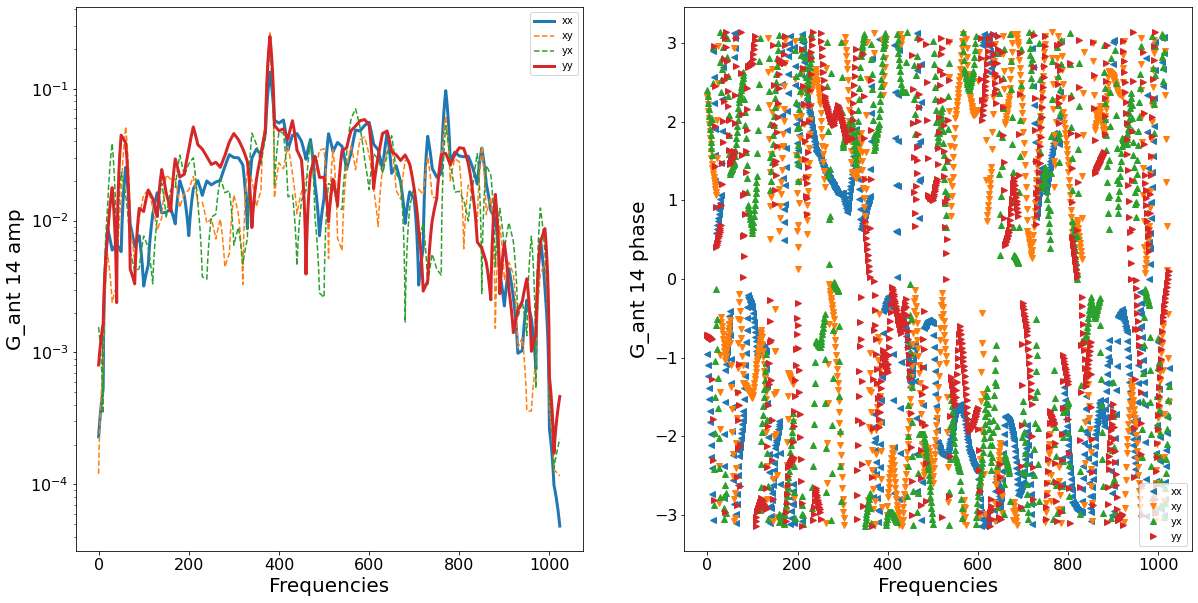

In [19]:
for ant_index in range(gain_info.shape[0]):
    fig, axes = plt.subplots(figsize=(20,10), ncols=2)
    
    ax = axes[0]
    ax.plot(abs(gain_rp[ant_index,:,0,0]), lw=3, label="xx")
    ax.plot(abs(gain_rp[ant_index,:,0,1]), "--", label="xy")
    ax.plot(abs(gain_rp[ant_index,:,1,0]), "--", label="yx")
    ax.plot(abs(gain_rp[ant_index,:,1,1]), lw=3, label="yy")
    ax.set_yscale('log')
    ax.tick_params(axis='both', which='both', labelsize=16)
    ax.set_xlabel("Frequencies", fontsize=20)
    ax.set_ylabel("G_ant {} amp".format(ant_index), fontsize=20)
    ax.legend(loc='upper right')
    
    ax = axes[1]
    ax.plot(np.angle(gain_rp[ant_index,:,0,0]), "<", label="xx")
    ax.plot(np.angle(gain_rp[ant_index,:,0,1]), "v",label="xy")
    ax.plot(np.angle(gain_rp[ant_index,:,1,0]), "^",label="yx")
    ax.plot(np.angle(gain_rp[ant_index,:,1,1]), ">",label="yy")
    ax.tick_params(axis='both', which='both', labelsize=16)
    ax.set_xlabel("Frequencies", fontsize=20)
    ax.set_ylabel("G_ant {} phase".format(ant_index), fontsize=20)
    ax.legend(loc='lower right')